# PSTAT131 Final Project
Sean Gao, Aya Zeplovitch

## Introduction 

This project aims to predict the number of comments given the question of any [r/Askreddit](https://www.reddit.com/r/AskReddit/) question. r/Askreddit is a forum where redditors (Reddit users) post questions (about anything really). We try to find the answer to the following question: "what kind of r/Askreddit questions garner the most interactions?" This is an interesting question because as someone that regularly browses Reddit, there definitely exists a pattern between the posts that become popular.

***

## NLP

As our data is going to be text data, we will have to use NLP techniques to transform text into machine readable dataframes. The most common techniques used are word-embedding, and bag-of-words. Here's approximately how they work:

Suppose we have the following sentence: *"I like my big pancakes"*

We can make our list of vocabulary from this sentence: **'I', 'like', 'my', big', 'pancakes'**. Both techniques uses the one-hot (or multi-hot in the case of bag-of-words) encoding (i.e., the word 'like' would be represented by a vector **[0, 1, 0, 0, 0]**). 

###  Word-embedding

In the case of word-embedding, a $m \times n$ matrix will be created, where $m$ is the number of words in the sentence, and $n$ is the number of words in our total vocabulary. As such, our sentence will be represented as such:

||I|like|my|big|pancakes|
|---|---|---|---|---|---|
|1|1|0|0|0|0|
|2|0|1|0|0|0|
|3|0|0|1|0|0|
|4|0|0|0|1|0|
|5|0|0|0|0|1|

### Bag-of-words

In the case of bag-of-words, a single array of length $m$ will be created. The value at each index will be the number of occurrences of the word that index represents. With the same vocabulary, *'I like pancakes.'* would be represented as such:

|I|like|my|big|pancakes|
|---|---|---|---|---|
|1|1|0|0|1|

### Word-embedding vs bag-of-words

Word-embedding 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

In [2]:
PCT_DATA = .01
N_VOCAB = 100

In [3]:
def rm_stop(words):
    new_words = []
    stop_words = nltk.corpus.stopwords.words('english')

    for w in words:
        if w not in stop_words:
            new_words.append(w)
    return new_words

def build_data(pct_data=PCT_DATA):
    raw_df = pd.read_csv('data/finaldataset.csv')
    raw_df = raw_df.iloc[:round(raw_df.shape[0] * pct_data)]

    df = raw_df[['num_comments', 'title']]
    del raw_df

    df.loc[:,'title'] = df['title'].str.lower()
    tokenizer = nltk.RegexpTokenizer(r'\b[(a-z)]+\b')

    df.loc[:,'tokenized'] = df['title'].apply(tokenizer.tokenize)

    df['tokenized'] = df['tokenized'].apply(rm_stop)
    df['text'] = df['tokenized'].apply(lambda x: ' '.join([word for word in x]))

    return df

def fit_n_vocab(df, n_vocab=N_VOCAB):
    vectorizer = CountVectorizer(max_features=n_vocab)
    vecfit = vectorizer.fit_transform(df['text'])
    X = vecfit.toarray()

    vocab = vectorizer.get_feature_names()
    Y = df['num_comments'].to_numpy()

    return X, Y, vocab, vectorizer 

def pct_no_words(X):
    return sum(np.sum(X, axis=1) > 0)/X.shape[0]

def pred_from_str(q, m, vec):
    tokenizer = nltk.RegexpTokenizer(r'\b[(a-z)]+\b')

    q = tokenizer.tokenize(q)
    q = rm_stop(q)

    j = lambda x: ' '.join([word for word in x])
    q = j(q)
    pred_X = vec.transform(pd.Series(q)).toarray()

    pred = m.predict(pred_X)

    return pred

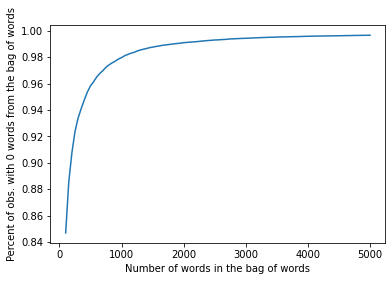

In [4]:
# set run = True if first time running, False otherwise as it takes a while to run
run = False

if run:
    pct_vals = []
    df = build_data()

    for i in tqdm(np.arange(100, 5001, 50)):
        X = fit_n_vocab(df=df, n_vocab=i)[0]
        pct = pct_no_words(X)
        pct_vals.append([i, pct])
    pct_df = pd.DataFrame(pct_vals, columns=['n_vocab', 'pct_words'])
    pct_df.to_csv('pct_df.csv')
else:
    pct_df = pd.read_csv('pct_df.csv')

plt.plot(pct_df['n_vocab'], pct_df['pct_words'])
plt.xlabel('Number of words in the bag of words')
plt.ylabel('Percent of obs. with 0 words from the bag of words')

plt.show()

In [5]:
df = build_data()
X, Y, vocab, vectorizer = fit_n_vocab(df=df, n_vocab=N_VOCAB)


# Y transformation
Y = np.log(Y, dtype=float)

del df

C:\Users\Sean\AppData\Local\Temp\ipykernel_8816\4069117706.py:11: DtypeWarning: Columns (7,8,61,62,66,67,70,71,72,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('data/finaldataset.csv')
C:\Users\Sean\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(array([3.279e+03, 4.125e+03, 2.126e+03, 3.370e+02, 6.200e+01, 2.100e+01,
        9.000e+00, 8.000e+00, 4.000e+00, 7.000e+00]),
 array([1.09861229, 1.98653168, 2.87445107, 3.76237047, 4.65028986,
        5.53820925, 6.42612865, 7.31404804, 8.20196743, 9.08988682,
        9.97780622]),
 <BarContainer object of 10 artists>)

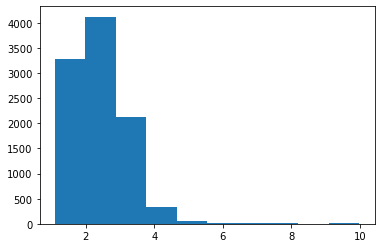

In [49]:
plt.hist(Y)

In [6]:
import statsmodels.api as sm

ols = sm.OLS(Y, X)
ols_fit = ols.fit()

# https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe
vocab_coeff_df = pd.DataFrame({'word': vocab, 'coeff': ols_fit.params, 'pval': ols_fit.pvalues})

In [7]:
vocab_coeff_df.sort_values('coeff', ascending=False)

,word,coeff,pval
54,opinion,1.835214,4.451592e-22
19,favourite,1.719135,5.712537e-21
81,thoughts,1.693542,5.618813e-21
5,biggest,1.687383,4.545969e-24
18,favorite,1.574314,5.476186e-59
...,...,...,...
75,take,0.247871,1.940359e-01
51,new,0.216357,2.445209e-01
24,friend,0.193925,1.816036e-01
10,could,0.179389,7.600573e-02


In [6]:
df = pd.DataFrame(data = X)
df['Y'] = Y

training_data = df.sample(frac = 0.8, random_state = 25)  # random_state serves as a seed
testing_data = df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

del df

No. of training examples: 7982
No. of testing examples: 1996


In [7]:
X_train = training_data.drop('Y', axis = 1)
X_test = testing_data.drop('Y', axis = 1)

Y_train = training_data['Y']
Y_test = testing_data['Y']

del training_data
del testing_data

In [36]:
from scipy import stats

# code from: https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
def make_lr_dict(m, y, p):
    params = np.append(linReg.intercept_,linReg.coef_)
    predictions = p

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    #p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    return myDF3.drop([0])

In [14]:
from sklearn.ensemble import RandomForestRegressor

randForest = RandomForestRegressor().fit(X_train, Y_train)
scores = cross_val_score(randForest, X_train, Y_train, cv = 5)
scores

array([-0.13508352, -0.12277632, -0.06752203, -0.10442074, -0.11076994])

In [12]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression().fit(X_train, Y_train)
lin_ypred = linReg.predict(X_train)
print(mean_squared_error(Y_train, lin_ypred))

scorelin = cross_val_score(LinearRegression(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scorelin.mean())

0.676335929737053
0.6941848249960213


In [38]:
lr_df = make_lr_dict(linReg, Y_train, lin_ypred)
lr_df['word'] = vocab
lr_df.sort_values(by=['Coefficients'], ascending=False)

,Coefficients,Standard Errors,t values,Probabilities,word
69,0.6239,0.069,9.028,NaN,sex
55,0.2262,0.083,2.729,NaN,opinion
20,0.2147,0.080,2.690,NaN,favourite
53,0.2096,0.079,2.670,NaN,old
86,0.1828,0.082,2.231,NaN,us
...,...,...,...,...,...
52,-0.2541,0.081,-3.141,NaN,new
18,-0.2583,0.069,-3.751,NaN,family
17,-0.2974,0.075,-3.980,NaN,experience
46,-0.4353,0.067,-6.468,NaN,moment


In [24]:
lr_df

,Coefficients,Standard Errors,t values,Probabilities
0,2.4888,0.012,199.614,NaN
1,-0.0990,0.062,-1.601,NaN
2,0.0228,0.062,0.366,NaN
3,-0.0657,0.080,-0.819,NaN
4,-0.0915,0.036,-2.517,NaN
...,...,...,...,...
96,-0.0514,0.049,-1.059,NaN
97,0.0144,0.046,0.311,NaN
98,0.0074,0.023,0.324,NaN
99,-0.1895,0.063,-3.012,NaN


In [ ]:
df

In [16]:
from sklearn.linear_model import Lasso

lassoReg = Lasso().fit(X_train, Y_train)
lassoReg.score(X_train, Y_train)

0.0

In [56]:
from sklearn.linear_model import Ridge

ridgeReg = Ridge().fit(X_train, Y_train)
ridge_ypred = ridgeReg.predict(X_train)
print(mean_squared_error(Y_train, ridge_ypred))

scoreridge = cross_val_score(Ridge(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreridge.mean())

0.6763387097664976
0.6939658846812932


In [60]:
import statsmodels.api as sm

ols = sm.OLS(Y_train, X_train)
ols_fit = ols.fit()

ols_ypred = ols_fit.predict(X_train)
print(mean_squared_error(Y_train, ols_ypred))

2.828248869367714


In [59]:
del ols
del ols_fit

In [43]:
from sklearn.neural_network import MLPRegressor

mlpReg = MLPRegressor(max_iter = 500, random_state = 1).fit(X_train, Y_train)
#print(mlpReg.score(X_train, Y_train))

ypred = mlpReg.predict(X_train)
print(mean_squared_error(Y_train, ypred))

scoreMLP = cross_val_score(MLPRegressor(max_iter = 500, random_state = 1), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreMLP.mean())



0.4232551898203105
0.9373989289273446


In [52]:
from sklearn.neighbors import KNeighborsRegressor

kReg = KNeighborsRegressor().fit(X_train, Y_train)
k_ypred = kReg.predict(X_train)
print(mean_squared_error(Y_train, k_ypred))

scoreK = cross_val_score(KNeighborsRegressor(), X_train, Y_train, cv = 5, 
                           scoring = 'neg_mean_squared_error')
print(-1*scoreK.mean())



0.7199426985446578
0.8282334772548527


In [19]:
X_train.shape, Y_train.shape

((159644, 500), (159644,))

In [20]:
X_test.shape, Y_test.shape

((39911, 500), (39911,))